# GHCN Weather Data
NOAA’s Global Historical Climatology Network (GHCN) collects climate summaries from thousands of weather stations around the globe. Two GHCN data sets, GHCN-D and GHCN-M are publicly available on Google BigQuery. The GHCN-D data set summarizes observed conditons by day, while GHCN-M provides summarized obsevations by month. Descriptions for both the [daily](https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/readme.txt) and [monthly](https://www1.ncdc.noaa.gov/pub/data/ghcn/v4/readme.txt) data sets are available through NOAA's website. In this notebook we will explore precipitation totals near a given landmark using the GHCN-D data set.

We start by importing the necessary libraries and setting the `GOOGLE_APPLICATION_CREDENTIALS` environment variable to the path that our Google BigQuery credential file is stored in (see Google's documentation on [Getting started with authentication](https://cloud.google.com/docs/authentication/getting-started) for details). The path to our credentials is stored in `google_app_cred.py`.

In [1]:
# Load bigquery magic and import neccessary libraries
%load_ext google.cloud.bigquery
import google_app_cred
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Set environment variable for bigquery credentials
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = google_app_cred.CREDENTIAL_PATH

## Precipitation Totals near a Given Landmark
### Station Selection
Since we are looking for precipitation totals near a given landmark, we will first have to select a station near that landmark. The landmark used in this notebook is [Jackson Falls](https://www.fs.usda.gov/recarea/shawnee/recarea/?recid=32359), a popular rock climbing destination in Shawnee National Forest. The latitude and longitude for this landmark have been copied from the US Forest Service website. 

In [2]:
# Set coordinates of landmark
landmark_lat = 37.509167
landmark_lon = -88.68305
coordinates = {'landmark_lat': landmark_lat, 'landmark_lon': landmark_lon}

With our parameters set, we are ready to query the `ghcnd_stations` table in the ghcn_d database. We will restrict our search to stations within 0.1 degrees of latitude and longitude of our chosen landmark.

In [3]:
%%bigquery stations --params $coordinates
SELECT
  id,
  name,
  state,
  latitude,
  longitude
FROM
  `bigquery-public-data.ghcn_d.ghcnd_stations`
WHERE
  latitude > @landmark_lat - 0.1
  AND latitude < @landmark_lat + 0.1
  AND longitude > @landmark_lon - 0.1
  AND longitude < @landmark_lon + 0.1

Downloading: 100%|██████████| 6/6 [00:03<00:00,  1.93rows/s]


Let us preview the returned dataframe.

In [4]:
# Preview returned stations
stations.head(10)

,id,name,state,latitude,longitude
0,USC00112651,EDDYVILLE,IL,37.5000,-88.5833
1,USC00113482,DIXON SPRINGS AGR CTR,IL,37.4333,-88.6667
2,USC00116093,NEW BURNSIDE,IL,37.5833,-88.7667
3,USC00112353,DIXON SPRINGS AGRIC CTR,IL,37.4389,-88.6678
4,USR0000IDIX,DIXON SPRINGS ILLINOIS,IL,37.4361,-88.6672
5,US1ILJH0001,NEW BURNSIDE 1.8 ENE,IL,37.5884,-88.7432


We have six possible stations to choose from. To simplify our analysis, let us choose the station that is closest to our landmark. Given that each station is relatively near the others, we will treat the latitude and longitude as points on a cartesian plane. This allows us to use the Euclidean distance (the standard "distance formula") as our measure of distance.

In [5]:
# Calculate Euclidean distance from landmark to stations
stations['coordinate_dist'] = np.sqrt((stations['latitude'] - landmark_lat)**2 + 
                                      (stations['longitude'] - landmark_lon)**2)
stations.sort_values(by='coordinate_dist')

,id,name,state,latitude,longitude,coordinate_dist
3,USC00112353,DIXON SPRINGS AGRIC CTR,IL,37.4389,-88.6678,0.071903
4,USR0000IDIX,DIXON SPRINGS ILLINOIS,IL,37.4361,-88.6672,0.074766
1,USC00113482,DIXON SPRINGS AGR CTR,IL,37.4333,-88.6667,0.077609
5,US1ILJH0001,NEW BURNSIDE 1.8 ENE,IL,37.5884,-88.7432,0.099478
0,USC00112651,EDDYVILLE,IL,37.5000,-88.5833,0.100170
2,USC00116093,NEW BURNSIDE,IL,37.5833,-88.7667,0.111772


The `DIXON SPRINGS AGRIC CTR` station is closest to our landmark, so we will start with selecting this station. 

In [6]:
# Select station closest to landmark
closest_station = stations.loc[3, 'id']
station_params = {'station_id': closest_station}

### Total Monthly Precipitation

Now that we have selected a station, we can aggregate precipitation data from that station. The GHCN-D data set is broken into tables by year, so we will focus on 2020 since it is the latest year for which we will have complete data. We will start by summing the total precipitation for each month.

In [7]:
%%bigquery monthly_precip --params $station_params
SELECT
  EXTRACT(MONTH FROM date) AS month,
  SUM(value) AS total_precip
FROM
  `bigquery-public-data.ghcn_d.ghcnd_2020`
WHERE
  id = @station_id
  AND element = "PRCP"
GROUP BY 
  1
ORDER BY 1

Downloading: 100%|██████████| 11/11 [00:02<00:00,  3.76rows/s]


We will sort by month and view the totals for each month. Note that the quantity given is in tenths of millimeters. 

In [8]:
# Preview data
monthly_precip

,month,total_precip
0,1,410.0
1,2,854.0
2,3,491.0
3,4,0.0
4,5,105.0
5,6,419.0
6,7,628.0
7,8,255.0
8,9,8.0
9,10,1238.0


The month of November is missing entirely from this data set, and both April and December have a total of 0 tenths of a millimeter. While this could indicate that there was no measurable precipitation at that station for those three months, it seems more likely that the data from this station is incomplete.

Let us try pulling data for every station within our 0.1 degree range to see if any station has more complete data.

In [9]:
%%bigquery stations_monthly --params $coordinates

WITH stations AS (
  SELECT
    id,
    name
  FROM
    `bigquery-public-data.ghcn_d.ghcnd_stations`
  WHERE
    latitude > @landmark_lat - 0.1
    AND latitude < @landmark_lat + 0.1
    AND longitude > @landmark_lon - 0.1
    AND longitude < @landmark_lon + 0.1
)

SELECT
  EXTRACT(MONTH FROM date) AS month,
  s.name AS station,
  SUM(value) AS total_precip
FROM
  stations AS s
LEFT JOIN
  `bigquery-public-data.ghcn_d.ghcnd_2020` AS d
  ON s.id = d.id
WHERE
  d.element = "PRCP"
GROUP BY 
  1, 2
ORDER BY
  1, 2

Downloading: 100%|██████████| 23/23 [00:03<00:00,  7.64rows/s]


Let us count how many times each station occurs in the returned dataframe.

In [10]:
stations_monthly['station'].value_counts()

NEW BURNSIDE 1.8 ENE              12
DIXON SPRINGS AGRIC CTR           11
Name: station, dtype: int64

Interestingly, only two of the stations recorded precipitation data in 2020. Let us take a closer look at the data for the `NEW BURNSIDE 1.8 ENE` station to see if it seems reasonable. We will also remove whitespace from around the station names to make subsetting the dataframe easier.

In [11]:
# Strip station names and sort by month
stations_monthly['station'] = stations_monthly['station'].str.strip()

# Select only New Burnside 
stations_monthly[stations_monthly['station'] == 'NEW BURNSIDE 1.8 ENE']

,month,station,total_precip
1,1,NEW BURNSIDE 1.8 ENE,1571.0
3,2,NEW BURNSIDE 1.8 ENE,925.0
5,3,NEW BURNSIDE 1.8 ENE,1641.0
7,4,NEW BURNSIDE 1.8 ENE,477.0
9,5,NEW BURNSIDE 1.8 ENE,1134.0
11,6,NEW BURNSIDE 1.8 ENE,1857.0
13,7,NEW BURNSIDE 1.8 ENE,729.0
15,8,NEW BURNSIDE 1.8 ENE,1119.0
17,9,NEW BURNSIDE 1.8 ENE,620.0
19,10,NEW BURNSIDE 1.8 ENE,2124.0


These values seem much more reasonable than those from the first station. Let us select only the observations from `NEW BURNSIDE 1.8 ENE` for the rest of this analysis. We will also want to convert the `total_precip` column to inches.

In [12]:
# Change earlier parameters
selected_station = stations.loc[5, 'id']
station_params = {'station_id': selected_station}

# Filter by station, sort by month, and set month as index
monthly_clean = stations_monthly[stations_monthly['station'] == 'NEW BURNSIDE 1.8 ENE'].copy()
monthly_clean.set_index('month', inplace=True)

# Convert from tenths of a millimeter to inches
monthly_clean['total_precip'] /= 254
monthly_clean

,station,total_precip
month,,
1,NEW BURNSIDE 1.8 ENE,6.185039
2,NEW BURNSIDE 1.8 ENE,3.641732
3,NEW BURNSIDE 1.8 ENE,6.460630
4,NEW BURNSIDE 1.8 ENE,1.877953
5,NEW BURNSIDE 1.8 ENE,4.464567
6,NEW BURNSIDE 1.8 ENE,7.311024
7,NEW BURNSIDE 1.8 ENE,2.870079
8,NEW BURNSIDE 1.8 ENE,4.405512
9,NEW BURNSIDE 1.8 ENE,2.440945


Now that we have a clean dataframe to work with, we can plot the data using Pandas' built in plotting function and matplotlib.

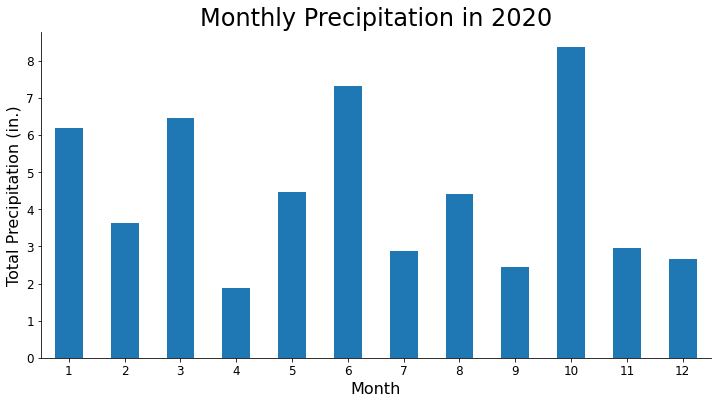

In [13]:
# Create figure and axis objects
fig, ax = plt.subplots(figsize=(12, 6))

# Plot data, despine figure, and format plot
monthly_clean.plot.bar(ax=ax, legend=False, rot=0)
sns.despine()
ax.set_ylabel('Total Precipitation (in.)', fontsize=16)
ax.set_xlabel('Month', fontsize=16)
ax.set_title('Monthly Precipitation in 2020', fontsize=24)
ax.tick_params(labelsize=12)

We see that October was the wettest month in Southern Illinois in 2020 according to the observations collected at this station, and April received the least precipitation. These results are somewhat surprising, as there is typically less preicipitaion in the Fall months than in the Spring in Illinois.  

### Number of Days with Precipitation
Since our chosen landmark is a rock climbing destination, we will look at one other measure relevant to that activity. Volume of rain is certainly important in determining whether conditions are suitable, but any amount of precipitation can cause problems. Becuase of this, we will also look at the number of days that any precipitation was recorded per month. We will continue to use the readings from the `NEW BURNSIDE 1.8 ENE` station since those were the most complete.

In [14]:
%%bigquery days_with_precip --params $station_params
SELECT
  EXTRACT(MONTH FROM date) AS month,
  COUNT(DISTINCT EXTRACT(DAY FROM date)) AS days_with_precip
FROM
  `bigquery-public-data.ghcn_d.ghcnd_2020`
WHERE
  id = @station_id
  AND element = "PRCP"
  AND value > 0
GROUP BY 
  1
ORDER BY
  1

Downloading: 100%|██████████| 12/12 [00:02<00:00,  4.08rows/s]


In [15]:
# Preview data
days_with_precip

,month,days_with_precip
0,1,12
1,2,11
2,3,11
3,4,11
4,5,19
5,6,9
6,7,10
7,8,12
8,9,6
9,10,9


At a glance, these appear to be reasonable results. The values for number of days with precipitaion range between 6 and 19 per month. It would be concerning if there were more than 30 or less than 1 or 2.

Let us set the month as the index then plot the results.

In [16]:
# Set month as index
days_clean = days_with_precip.set_index('month')
days_clean

,days_with_precip
month,
1,12
2,11
3,11
4,11
5,19
6,9
7,10
8,12
9,6


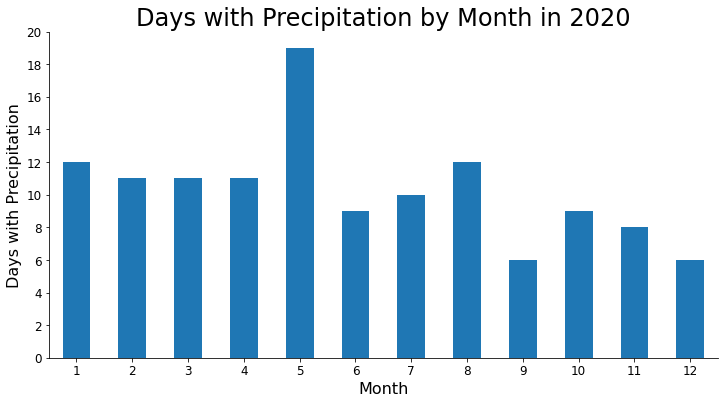

In [17]:
fig, ax = plt.subplots(figsize=(12, 6))
days_clean.plot.bar(ax=ax, legend=False, rot=0)
sns.despine()
ax.set_ylabel('Days with Precipitation', fontsize=16)
ax.set_xlabel('Month', fontsize=16)
ax.set_title('Days with Precipitation by Month in 2020', fontsize=24)
ax.set_yticks(np.arange(0,21,2))
ax.tick_params(labelsize=12)

We see that May had by far the most days with some amount of precipitation, and there were generally fewer days with precipitation towards the end of the year. With this, it may be interesting to find the average amount of precipitation per precipitation event per month.

### Amount of Precipitaion per Day with Precipitation
Finding the averag amount of precipitation per rainy day within a month is relatively trivial. All we will need to is divide the number of days with precipitation by the total amount of precipitation.

In [18]:
amount_per_event = monthly_clean['total_precip'] / days_clean['days_with_precip']
amount_per_event

month
1     0.515420
2     0.331067
3     0.587330
4     0.170723
5     0.234977
6     0.812336
7     0.287008
8     0.367126
9     0.406824
10    0.929134
11    0.369587
12    0.444882
dtype: float64

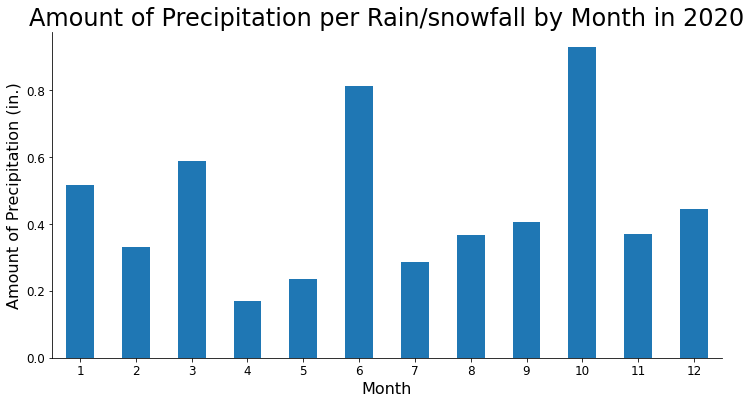

In [19]:
fig, ax = plt.subplots(figsize=(12, 6))
amount_per_event.plot.bar(ax=ax, legend=False, rot=0)
sns.despine()
ax.set_ylabel('Amount of Precipitation (in.)', fontsize=16)
ax.set_xlabel('Month', fontsize=16)
ax.set_title('Amount of Precipitation per Rain/snowfall by Month in 2020', fontsize=24)
ax.tick_params(labelsize=12)

We see that October and June had particularly large storms on average, while months such as April and May had relatively small showers.

## Data Sources
GHCN-D: https://console.cloud.google.com/marketplace/product/noaa-public/ghcn-d

GHCN-M: https://console.cloud.google.com/marketplace/product/noaa-public/ghcn-m